<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_4/assignment_4_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1: Adil

# Student 2: Anvitha

# Student 3: Srinidhi Ilango

# Imports

In [1]:
import numpy as np
import pickle
import requests
import torch

# other imports go here



# Data loading and inspection

In [2]:
# load and inspect data
data_location = 'https://surfdrive.surf.nl/files/index.php/s/K3ArFDQJb5USQ6K/download'
data_request = requests.get(data_location)
full_data = pickle.loads(data_request.content)

# Data augmentation and pipeline

In [ ]:
full_data.keys()

dict_keys(['unlabeled_data', 'labeled_data', 'representative_set_1', 'representative_set_2'])

In [3]:
# add data augmentation

from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, data, labels = None):
        self.data = torch.FloatTensor(data)
        if labels is not None:
            self.labels = torch.FloatTensor(labels)
        else:
            self.labels = None

    def __getitem__(self, index):
        x = self.data[index]  
        x = x / 255 # normalize
        if self.labels is not None:
            y = self.labels[index] # .view(1,2,5)
        else:
            y = np.array([])
        return x, y

    def __len__(self):
        return len(self.data)

In [4]:
# 26000 unlabelled and 2000 labelled datasets: combine and shuffle
unlablled_id = np.zeros((26000,6))
unlablled_id[:,-1] = 1
# unlabeled_train=MyDataset(full_data['unlabeled_data'],unlablled_id )


padded_lables = np.pad(full_data['labeled_data']['labels'], (0,1), "constant", constant_values=0)[:-1]
# labeled_train = MyDataset(full_data['labeled_data']['data'],padded_lables )
train_x = np.append(full_data['unlabeled_data'], full_data['labeled_data']['data'],axis=0)
train_y = np.append(unlablled_id, padded_lables,axis=0)
train = MyDataset(train_x, train_y)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
# labelled =  torch.utils.data.DataLoader(labeled_train, batch_size=batch_size)

# Model definitions

In [5]:
import torch.nn.functional as F
from torch import nn


class Classifier(nn.Module):
    """
    A 2-layer convolutional NN with dropout and batch-normalization 
    Dimension progression: 
        (if raw resolution = 96). 96*96*3 -> 96*96*10 -> 48*48*10 -> 48*48*20 -> 12*12*20 -> 64 -> 10 
        (if raw resolution = 96). 32*32*1 -> 32*32*10 -> 16*16*10 -> 8*8*20 -> 4*4*20 -> 64 -> 5 
    """
    def __init__(self, image_reso, filter_size, dropout_rate):
        super(Classifier, self).__init__()
        
        assert filter_size % 2 == 1, "filter_size = %r but it has to be an odd number" % filter_size
        
        # 3 input channels, 10 output channels, 5 x 5 filter size
        self.conv1_drop = nn.Dropout2d(dropout_rate)
        self.conv1 = nn.Conv2d(1, 10, kernel_size=filter_size, stride = 1, padding = (filter_size - 1)//2)  
        self.bn1 = nn.BatchNorm2d(num_features=10)
        
        # reduce spatial dimension by 2 times
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding = 0)   
        
        # 10 input channels, 20 output channels, 5 x 5 filter size
        self.conv2_drop = nn.Dropout2d(dropout_rate)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=filter_size, stride = 1, padding = (filter_size - 1)//2)
        self.bn2 = nn.BatchNorm2d(num_features=20)
        
        # reduce spatial dimension by 4 times 
        self.avgpool = nn.AvgPool2d(kernel_size=4)  
        
        self.fc1 = nn.Linear(20 * (image_reso//8) * (image_reso//8), 64)
        self.fc2 = nn.Linear(64, 6)        

    def forward(self, x):
                
        # 1 x 32 x 32 -> 10 x 32 x 32 
        x = self.conv1_drop(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
         
        # 10 x 32 x 32 -> 10 x 16 x 16
        x = self.pool1(x)
        
        # 10 x 16 x 16 -> 20 x 8 x 8
        x = self.conv2_drop(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)     
        
        # 20 x 8 x 8 -> 20 x 4 x 4
        x = self.avgpool(x)
               
        # resize the 2d representation to a vector
        x = x.view(-1, 20 * 4 * 4)
    
        # 1 x (20 * 12 * 12) -> 1 x 64 
        x = F.relu(self.fc1(x))

        # 1 x 64 -> 1 x 5 
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [6]:
# reference: https://github.com/wohlert/semi-supervised-pytorch/blob/master/semi-supervised/models/dgm.py
def log_standard_categorical(p):
    """Calculates the cross entropy between a (one-hot) categorical vector
    and a standard (uniform) categorical distribution.
    Parameters
    ----------
    p: one-hot categorical distribution
    """
    # Uniform prior over y
    prior = F.softmax(torch.ones_like(p), dim=1)
    prior.requires_grad = False

    cross_entropy = -torch.sum(p * torch.log(prior + 1e-8), dim=1)

    return cross_entropy

# -L(x,y), elbo for labeled data
def _L(x,y,recon_x,mu,logvar):
    n, d = mu.shape
    loglik = -F.binary_cross_entropy(recon_x, x, reduction='sum')/n
    KLD = -0.5*(d + (logvar-logvar.exp()).sum()/n - mu.pow(2).sum()/n)
    loglik_y = -log_standard_categorical(y).sum()/n
    
    return loglik + loglik_y - KLD

# elbo for unlabeled data
def _U(x,log_prob,recon_x,mu,logvar):
    n, d = mu.shape  
    prob = torch.exp(log_prob)
    
    #Entropy of q(y|x)
    H = -torch.mul(prob,log_prob).sum(1).mean()
    
    # -L(x,y)
    loglik = -F.binary_cross_entropy(recon_x, x, reduction='none').sum(1).sum(1).sum(1) #n*1
    KLD = -0.5*(d + (logvar-logvar.exp()) - mu.pow(2)).sum(1) #n*1
    
    
    if (x.is_cuda):
        y = torch.cuda.FloatTensor((1,0,0,0,0,0)).reshape(1,-1)
    else:
        y = torch.FloatTensor((1,0,0,0,0,0)).reshape(1,-1)

    loglik_y = -log_standard_categorical(y)  #constant, value same for all y since we have a uniform prior
    
    _Lxy = loglik + loglik_y - KLD #n*1
    
    # sum q(y|x) * -L(x,y) over y
    q_Lxy = torch.sum(prob * _Lxy.view(-1,1))/n
    
    return q_Lxy + H


In [7]:
class EncoderModule(nn.Module):
    def __init__(self, input_channels, output_channels, stride, kernel, pad):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=kernel, padding=pad, stride=stride)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class Encoder(nn.Module):
    def __init__(self, color_channels, pooling_kernels, n_neurons_in_middle_layer):
        self.n_neurons_in_middle_layer = n_neurons_in_middle_layer
        super().__init__()
        self.bottle = EncoderModule(color_channels, 32, stride=1, kernel=1, pad=0)
        self.m1 = EncoderModule(32, 64, stride=1, kernel=3, pad=1)
        self.m2 = EncoderModule(64, 128, stride=pooling_kernels[0], kernel=3, pad=1)
        self.m3 = EncoderModule(128, 256, stride=pooling_kernels[1], kernel=3, pad=1)

    def forward(self, x):
        out = self.m3(self.m2(self.m1(self.bottle(x))))
        # return out
        # torch.Size([64, 1024]) : batch_size, c3 filters * 2,2
        return out.view(-1, self.n_neurons_in_middle_layer)

In [8]:
class DecoderModule(nn.Module):
    def __init__(self, input_channels, output_channels, stride, activation="relu"):
        super().__init__()
        self.convt = nn.ConvTranspose2d(input_channels, output_channels, kernel_size=stride, stride=stride)
        self.bn = nn.BatchNorm2d(output_channels)
        if activation == "relu":
            self.activation = nn.ReLU(inplace=True)
        elif activation == "sigmoid":
            self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.bn(self.convt(x)))

    
class Decoder(nn.Module):
    def __init__(self, color_channels, pooling_kernels, decoder_input_size):
        self.decoder_input_size = decoder_input_size
        super().__init__()
        self.m1 = DecoderModule(256, 128 , stride=1)
        self.m2 = DecoderModule(128, 64, stride=pooling_kernels[1])
        self.m3 = DecoderModule(64, 32, stride=pooling_kernels[0])
        self.bottle = DecoderModule(32, color_channels, stride=1, activation="sigmoid")

    def forward(self, x):
        out = x.view(-1, 256, self.decoder_input_size, self.decoder_input_size)
        out = self.m3(self.m2(self.m1(out)))
        return self.bottle(out)

In [9]:
class M2_base(nn.Module):
    def __init__(self, latent_features, classifier, num_labels = 10):
        """Structure of the M2 model
        Parameters
        ----------
        number of latent features,
        classifier for the model
        """
        super().__init__()
        
        self.n_latent_features = latent_features
        self.best_dev_accuracy = 0

        pooling_kernel = [4, 4]
        encoder_output_size = 2
        color_channels = 1
        

        # neurons int middle layer
        n_neurons_middle_layer = 256 * encoder_output_size * encoder_output_size

        # Encoder
        self.encoder = Encoder(color_channels, pooling_kernel, n_neurons_middle_layer)
        # Middle
        self.fc1 = nn.Linear(n_neurons_middle_layer + num_labels, self.n_latent_features )
        self.fc2 = nn.Linear(n_neurons_middle_layer + num_labels, self.n_latent_features)
        self.fc3 = nn.Linear(self.n_latent_features + num_labels, n_neurons_middle_layer)
        # Decoder
        self.decoder = Decoder(color_channels, pooling_kernel, encoder_output_size)
        self.classifier = classifier

    def _reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def _bottleneck(self, h, y):
        mu, logvar = self.fc1(torch.cat([h,y.float()],dim = 1)), self.fc2(torch.cat([h,y.float()],dim = 1))
        z = self._reparameterize(mu, logvar)
        return z, mu, logvar

    def _get_z(self, x,y):
        h = self.encoder(x)
        # return (h,y)
        # Bottle-neck
        z, mu, logvar = self._bottleneck(h,y)

        return z

    def forward(self, x, y):
        # Encoder
        h = self.encoder(x)
        # return (h,y)
        # Bottle-neck
        z, mu, logvar = self._bottleneck(h,y)
        # decoder
        z = self.fc3(torch.cat([z,y],dim = 1))
        d = self.decoder(z)
        return d, mu, logvar

# Training and validation loop

In [10]:
import torch.optim as optim


device = 'cuda'
classifier = Classifier(image_reso = 32, filter_size = 3, dropout_rate = 0.2)
model = M2_base(10,classifier=classifier,num_labels=6).to(device)


rep_1 = MyDataset(full_data['representative_set_1']['data'],full_data['representative_set_1']['labels'])
rep_1_loader = torch.utils.data.DataLoader(rep_1, batch_size=128)


model.train()
total_loss, accuracy = (0, 0)
alpha = 1.3 #0.1 * (26000/64) / (2000/64)

epochs = 20
optimizer = optim.Adam(model.parameters(), lr=1.0e-3)

for epoch in range(epochs):
    train_loss = 0
    correct = 0
    for batch_idx, data in enumerate(train_loader):
        data, labels = data
        data,labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data,labels)
        

        index_n = torch.nonzero(labels[:,-1]==1).reshape(-1)
        index_n = index_n.to(device)
        index = torch.nonzero(labels[:,-1]==0).reshape(-1)
        index = index.to(device)
        unlabeled_data = data.index_select(0,index_n)
        labeled_data = data.index_select(0,index)
        recon_unlabeled = recon_batch.index_select(0,index_n)
        recon_labeled = recon_batch.index_select(0,index)
        mu_unlabeled = mu.index_select(0,index_n)
        mu_labeled = mu.index_select(0,index)
        logvar_unlabeled = logvar.index_select(0,index_n)
        logvar_labeled = logvar.index_select(0,index)

        y_onehot = labels.index_select(0,index)

        # if there is no labeled data
        if (len(index) == 0):
            Lxy = 0
            classication_loss = 0
        else:
            # -Elbo for labeled data (L(X,y))
            Lxy = - _L(labeled_data,y_onehot,recon_labeled,mu_labeled,logvar_labeled)
            log_prob_l = model.classifier(labeled_data)
            # negative cross entropy
            classication_loss = -torch.sum(y_onehot * log_prob_l, dim=1).mean()

        log_prob = model.classifier(unlabeled_data)

        # -Elbo for unlabeled data (U(x))
        Ux = - _U(unlabeled_data,log_prob,recon_unlabeled,mu_unlabeled,logvar_unlabeled)

        # The overall loss
        loss = Lxy + alpha * classication_loss + Ux
        

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # if there is labeled data in this batch
        if ( len(index) > 0):
            target = labels.index_select(0,index)
            target = torch.argmax(target, dim=1).to(device)
            pred = log_prob_l.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() 

    model.eval()
    correct_val = 0
    cl_len = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(rep_1_loader):
            
            #all data are labeled
            data, labels = data
            data  = data.to(device)
            labels = labels.to(device)

            normal_n = torch.nonzero(labels[:,-1]==0).reshape(-1)
            cl_len+=len(normal_n)
            cl_data = data.index_select(0,normal_n)
            
            cl_label = labels.index_select(0,normal_n)
            cl_label = torch.argmax(cl_label, dim=1).to(device)
            cl_label = cl_label.to(device)
            
            log_prob = model.classifier(cl_data)

            pred = log_prob.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct_val += pred.eq(cl_label.view_as(pred)).sum().item()
            # break

    # print(f'val_accuracy:{correct_val/cl_len}')

    print(f'EPOCH:{epoch}  training loss:{train_loss/28000}   training accuracy:{correct/2000}  val_accuracy:{correct_val/cl_len}')


EPOCH:0  training loss:12.575091936383929   training accuracy:0.69  val_accuracy:0.928
EPOCH:1  training loss:6.7541731905255995   training accuracy:0.913  val_accuracy:0.937
EPOCH:2  training loss:6.409806646074568   training accuracy:0.9355  val_accuracy:0.949
EPOCH:3  training loss:6.312490222385952   training accuracy:0.9445  val_accuracy:0.955
EPOCH:4  training loss:6.23722322845459   training accuracy:0.9535  val_accuracy:0.957
EPOCH:5  training loss:6.220602675846645   training accuracy:0.9535  val_accuracy:0.962
EPOCH:6  training loss:6.1526807572501045   training accuracy:0.9635  val_accuracy:0.961
EPOCH:7  training loss:6.1440734318324495   training accuracy:0.9615  val_accuracy:0.961
EPOCH:8  training loss:6.122947375161307   training accuracy:0.966  val_accuracy:0.967
EPOCH:9  training loss:6.099418739318848   training accuracy:0.9695  val_accuracy:0.941
EPOCH:10  training loss:6.055093912942069   training accuracy:0.9705  val_accuracy:0.976
EPOCH:11  training loss:6.041067

# Inspection, Validation, and Analysis

In [28]:
#Performance in classification

from sklearn.metrics import confusion_matrix
import seaborn as sns 


rep_2 = MyDataset(full_data['representative_set_2']['data'],full_data['representative_set_2']['labels'])
rep_2_loader = torch.utils.data.DataLoader(rep_1, batch_size=1)

model.eval()
correct = 0
cl_len = 0
preds = []
y = []
with torch.no_grad():
    for batch_idx, data in enumerate(rep_2_loader):
        
        #all data are labeled
        data, labels = data
        data  = data.to(device)
        labels = labels.to(device)

        normal_n = torch.nonzero(labels[:,-1]==0).reshape(-1)
        cl_len+=len(normal_n)
        cl_data = data.index_select(0,normal_n)
        cl_label = labels.index_select(0,normal_n)

        
        cl_label = torch.argmax(cl_label, dim=1).to(device)
        cl_label = cl_label.to(device)
        
        log_prob = model.classifier(cl_data)

        pred = log_prob.max(1, keepdim=True)[1] # get the index of the max log-probability
        preds.append(pred)
        y.append(cl_label)

predicted = torch.cat(preds).view(-1)
actual = torch.cat(y)

print(f'accuracy:{predicted.eq(actual).sum().item()/ len(actual)}')

accuracy:0.972


accuracy:0.972


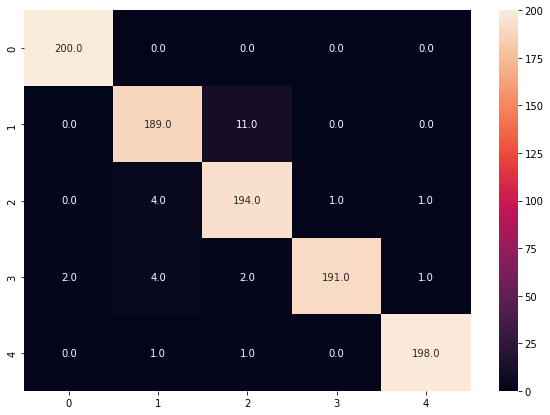

In [29]:
import matplotlib.pyplot as plt

print(f'accuracy:{predicted.eq(actual).sum().item()/ len(actual)}')
cm = confusion_matrix(actual.cpu(), predicted.cpu())

# import matplotlib.pyplot as plt
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt=".1f")

In [22]:
#  represneting the dataset as its modes
rep_2 = MyDataset(full_data['representative_set_2']['data'],full_data['representative_set_2']['labels'])
rep_2_loader = torch.utils.data.DataLoader(rep_1, batch_size=128)

model.eval()
output = []
out_y = []
for X,y in rep_2_loader:
    
    X= X.to(device)
    y = y.to(device)
    # print(X.shape, y.shape)
    output.append(model._get_z(X,y))
    out_y.append(y)


output = torch.cat(output, dim=0)
out_y = torch.cat(out_y, dim=0)

print(len(output))

1052


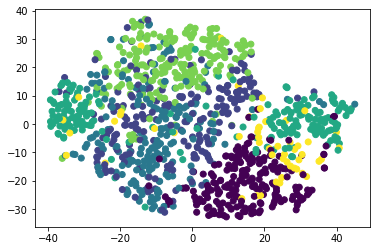

In [33]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(output.detach().cpu().numpy())

out_y = out_y.cpu().detach()
plt.scatter(X_embedded[:,0], X_embedded[:, 1], c=torch.argmax(out_y, dim=1))

In [34]:
# first find anomaly in the dataset, then predict the non-anomalous data into one of the 5 classes
def elbo_elementwise(x, x_reconstr, mu, log_sigma):
    reconstr_loss = torch.sum(nn.functional.mse_loss(x_reconstr, x, reduction='none'), dim=1)
    constant_term = 32 * 32 * 0.5 * np.log(np.pi)  # assuming sigma=1/sqrt(2)
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1, dim=1)
    elbo = - reconstr_loss - constant_term - kl_loss
    return elbo.view(-1,1), reconstr_loss.view(-1,1), kl_loss.view(-1,1)


elbo


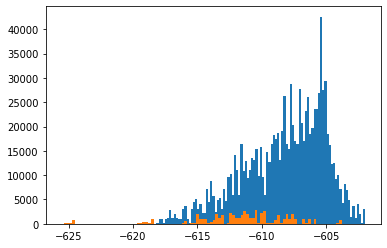

reconstruction loss


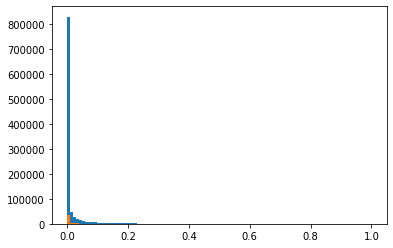

In [35]:
# detecting anomaly
rep_2 = MyDataset(full_data['representative_set_2']['data'],full_data['representative_set_2']['labels'])
rep_2_loader = torch.utils.data.DataLoader(rep_1, batch_size=1)

model.eval()
normal_test_elbo = []
anomaly_test_elbo = []
normal_test_rec = []
anomaly_test_rec = []

with torch.no_grad():
    for x,y in rep_2_loader:
        x = x.to(device)
        y = y.to(device)
        x_rec, mu, log_sigma = model(x,y)
        elbo, rec, kl = elbo_elementwise(x, x_rec, mu, log_sigma)

        if(y[...,-1] == 1):
            # print(y)
            anomaly_test_elbo.append(elbo.cpu().numpy())
            anomaly_test_rec.append(rec.cpu().numpy())
        else:
            normal_test_elbo.append(elbo.cpu().numpy())
            normal_test_rec.append(rec.cpu().numpy())

    normal_test_elbo = np.concatenate(normal_test_elbo, 0)
    anomaly_test_elbo = np.concatenate(anomaly_test_elbo, 0)
    normal_test_rec = np.concatenate(normal_test_rec, 0)
    anomaly_test_rec = np.concatenate(anomaly_test_rec, 0)

    print('elbo')
    plt.hist(normal_test_elbo, bins=100)
    plt.hist(anomaly_test_elbo, bins=100)
    plt.show()

    print('reconstruction loss')
    plt.hist(normal_test_rec, bins=100)
    plt.hist(anomaly_test_rec, bins=100)

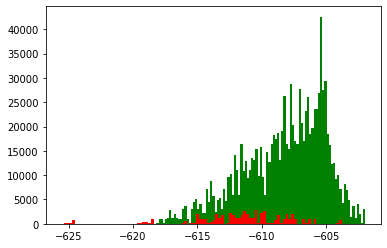

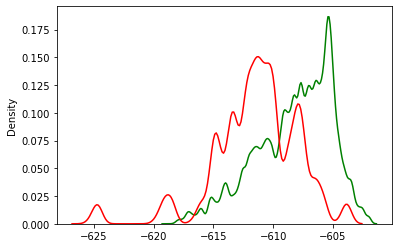

In [36]:
### density plot of elbo ###
import seaborn as sns

plt.hist(normal_test_elbo.reshape(-1), bins=100, color='green')
plt.hist(anomaly_test_elbo.reshape(-1), bins=100, color='red')
plt.show()

sns.kdeplot(normal_test_elbo.reshape(-1), color='green')
sns.kdeplot(anomaly_test_elbo.reshape(-1), color='red')
plt.show()


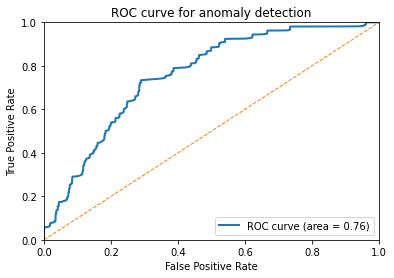

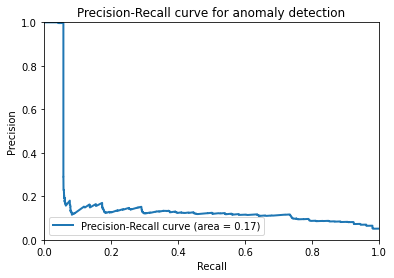

In [37]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

normal_test_labels = np.zeros_like(normal_test_elbo)
anomaly_test_labels = np.ones_like(anomaly_test_elbo)

scores = - np.concatenate([normal_test_elbo, anomaly_test_elbo], 0)
scores = (scores - scores.min())/(scores.max()-scores.min())

labels = np.concatenate([normal_test_labels, anomaly_test_labels], 0)
fpr, tpr, roc_thresholds = roc_curve(labels, scores)
precision, recall, pr_thresholds = precision_recall_curve(labels, scores)
roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision)

# print(f'{roc_auc=}')
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for anomaly detection')
plt.legend(loc='lower right')
plt.show()


# print(f'{pr_auc=}')
plt.figure()
plt.plot(recall, precision, lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for anomaly detection')
plt.legend(loc='lower left')
plt.show()